# Requirment 

In [ ]:
!python.exe -m pip install --upgrade pip

In [216]:
!pip install pytesseract
!pip install beautifulsoup4
!pip install pandas
# !pip install tensorflow
!pip install Pillow
!pip install lxml
!pip install opencv-python
!pip install pathlib
!pip install ast

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\User\AppData\Local\Temp\pip-install-cmvjdell\ast_af27a5a016f54dbf817e7d342a0d55fb\setup.py", line 6, in <module>
          README = codecs.open(os.path.join(here, 'AST/README'), encoding='utf8').read()
        File "C:\Users\User\AppData\Local\Programs\Python\Python38\lib\codecs.py", line 905, in open
          file = builtins.open(filename, mode, buffering)
      FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\AppData\\Local\\Temp\\pip-install-cmvjdell\\ast_af27a5a016f54dbf817e7d342a0d55fb\\AST/README'
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encount

# Import

In [10]:
from bs4 import BeautifulSoup
import base64
import pandas as pd
# import tensorflow as tf
from pytesseract import pytesseract
from PIL import Image
import glob
import cv2
import numpy as np
from pathlib import Path
from ast import literal_eval

# Main

C:\Users\User\Desktop\backup\brt\Projects\Crawing-List-of-Admitted-Schools-for-Students\data\department
長庚大學中醫學系
i: 
   0
i: <td align="right" scope="row" valign="middle"></td>   1
i: 
   2
i: <td align="right" scope="row" valign="middle" width="8%"><div align="center" class="leftred"></div></td>   3
i: 
   4
i: <td align="center" scope="row" valign="middle" width="28%"><div align="center">
<a href="https://www.com.tw/cross/checktestareaid_36_k5ZqaZdu_112.html" title="點擊看看==&gt;這試場同學,他們推上哪些校系">
<br/>考區 : 私立復旦高中 </a>
</div></td>   5
i: 
   6
i: <td align="center" width="8%">*&lt;img height="18" ,="" src=""&gt; </td>   7
i: 
   8
i: <td colspan="4"><div align="left">
<div align="left">
<table border="0" cellpadding="0" cellspacing="0" width="100%">
<tbody><tr align="left">
<td scope="row" width="7%"><div align="right">
<img align="absbottom" alt="分發錄取" border="0" height="23" src="./長庚大學中醫學系 - 112年大學 _ 科大交叉查榜-www.com.tw_files/putdep1.png" title="分發錄取" width="23"/>
</div></td>
<td scope="r
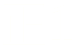
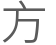
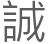
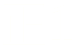
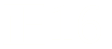
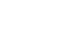
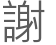
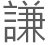
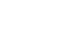
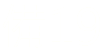
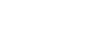
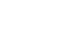
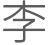
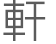
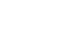
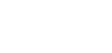
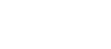
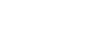
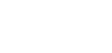
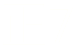
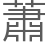
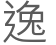
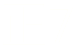
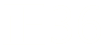
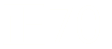
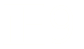

KeyboardInterrupt: 

In [15]:
%cd C:\Users\User\Desktop\backup\brt\Projects\Crawing-List-of-Admitted-Schools-for-Students\data\department\

for file in glob.iglob('*交叉查榜*.html'):
    # print(file)
    processing_department(file)

# Functions

In [4]:
def processing_department(filename):
    with open(filename, 'r', encoding="utf-8") as file:
        html = file.read()
        # print(html)
        soup = BeautifulSoup(html, 'html.parser')
    
    fields = ['rank', 'exam_location', 'stuno', 'univ',  'year', 'department_name', 'select']
    df = pd.DataFrame(columns=fields)
    df1 = pd.DataFrame(columns=fields)
    df2 = pd.DataFrame(columns=fields)
    
    department_name = []
    select = []

    str = soup.head.find_all('title')[0].text
    pos = str.find('年')
    year = str[pos-3:pos]  # str[5:8] str[5], str[6], str[7]

    str = soup.head.find_all('title')[0].text
    pos = str.find('-')
    univ = str[:pos].rstrip()

    dark_list = soup.body.find_all(bgcolor="#DEDEDC") # 褐色
    df1 = processing_list(univ, year, dark_list, df, department_name, select)
    # print(df1)
    
    white_list = soup.body.find_all(bgcolor="#FFFFFF") # 白色
    df2 = processing_list(univ, year, white_list, df, department_name, select)
    # print(df2)
    
    # make two df cross-interleave
    max_len = max(len(df1), len(df2))
    for line in range(max_len):
        if line < len(df1):
            df = pd.concat([df, df1.iloc[[line]]], ignore_index=True)
        if line < len(df2):
            df = pd.concat([df, df2.iloc[[line]]], ignore_index=True)
    
    # explode list into df
    df = df.explode(['department_name', 'select']).reset_index(drop=True)
    df = df.dropna()
    
    # save to csv
    result_dir = Path(r"C:\Users\User\Desktop\backup\brt\Projects\Crawing-List-of-Admitted-Schools-for-Students\result",f'{univ}.csv')
    df.to_csv(path_or_buf = result_dir, encoding='utf-8-sig', index=False)
    

In [14]:
def processing_list(univ, year, color_list, df, department_name, select):
    print(univ)
    for item in color_list:
        color_list_item_scope1 = item.children # get message under the soup.body.find_all(bgcolor="")
        count_item = 0
        for item_scope2 in color_list_item_scope1:
            # print("i:", item_scope2," ", count_item)
            """
            count_item:3 = 正備取
            count_item:5 = number
            count_item:9 = 錄取校系
            """
            if count_item == 3:
                try:
                    base64_str = item_scope2.find_all('img')[0]['src'].split(',')[1]
                except IndexError:
                    rank = "None"
                else:
                    with open("rank.png", "wb") as fh:
                        fh.write(base64.decodebytes(bytes(base64_str, 'utf-8')))
                    path_to_tesseract = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
                    pytesseract.tesseract_cmd = path_to_tesseract
                    thresholding_(r'rank.png')
                    path_to_image = r'rank.png'
                    rank = pytesseract.image_to_string(Image.open(path_to_image), lang='chi_tra', config='--oem 0 --psm 7')
                    
            elif count_item == 5:
                base64_str = item_scope2.find_all('img')[0]['src'].split(',')[1]
                with open("num.png", "wb") as fh:
                    fh.write(base64.decodebytes(bytes(base64_str, 'utf-8')))
                path_to_tesseract = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
                pytesseract.tesseract_cmd = path_to_tesseract
                thresholding_(r'num.png')
                path_to_image = r'num.png'
                stuno = pytesseract.image_to_string(Image.open(path_to_image), lang='eng', config='--oem 1 --psm 7')
                
            elif count_item == 9:
                tr_scope3 = item_scope2.find_all('tr')
                department_name = []
                select = []
                for item_scope4 in tr_scope3:
                    # print("item_scope4:", count, rank, item_scope4)
                    count_item_scope5 = 0
                    for item_scope5 in item_scope4:
                        # print('item_scope5:', count_, item_scope5)
                        """_summary_
                        count_item_scope5: 1 徽章
                        count_item_scope5: 3 大學
                        count_item_scope5: 5 校系排名
                        """
                        if count_item_scope5 == 1:
                            img_tag = item_scope5.find('img')
                            # print(img_tag)
                            if img_tag is not None:
                                img_tag_ = True
                            else:
                                img_tag_ = False
                            select.append(img_tag_)
                            
                        elif count_item_scope5 == 3:
                            # We'll drop later to suit up with img_tag_
                            if item_scope5.text != "":
                                department_name.append(item_scope5.text)
                            else:
                                department_name.append(np.nan)
                            
                        elif count_item_scope5 == 5:
                            # print(rank, img_tag_, select, department_name)
                            pass
                        
                        count_item_scope5 += 1

            count_item += 1
    
        x = item.find_all('a')
        exam_location = x[0].text[6:-1]
        
        dict = {'rank': rank, 'exam_location': exam_location, 'stuno': stuno, 'univ': univ, 'year': year, 'department_name': department_name, 'select': select}
        df = pd.concat([df, pd.DataFrame([dict])], ignore_index = True)
    
    return df

## Cv2

In [8]:
def thresholding_(png):
    if png[0:3] == "num":
        image = cv2.imread(png)
        gray = get_grayscale(image)
        thresh_ = thresholding(gray)
        cv2.imwrite('num.png', thresh_)
    else:
        image = cv2.imread(png)
        gray = get_grayscale(image)
        thresh_ = thresholding(gray)
        cv2.imwrite('rank.png', thresh_)        
  

In [9]:
# Convert the image to grayscale
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Remove noise from the image
def remove_noise(image):
    return cv2.medianBlur(image, 5)
 
# Thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Dilation
def dilate(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.dilate(image, kernel, iterations=1)
    
# Erosion
def erode(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.erode(image, kernel, iterations=1)

# Opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

# Canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

# Skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]

    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)